In [2]:
import numpy as np
import matplotlib.pyplot as plt
from Helper_functions import *
from numpy import linalg as la
import matplotlib.pyplot as plt
import cvxpy as cp

m = 500,ms = 500
converged after 1 iterations
m = 500,ms = 500
converged after 1 iterations
m = 500,ms = 500
converged after 1 iterations
m = 500,ms = 500
converged after 1 iterations
m = 500,ms = 500
converged after 1 iterations
m = 500,ms = 500
converged after 1 iterations
m = 500,ms = 500
converged after 2 iterations
m = 500,ms = 500
converged after 1 iterations
m = 500,ms = 500
converged after 1 iterations
m = 500,ms = 500
converged after 1 iterations
m = 493,ms = 500
did not converge
m = 489,ms = 500
did not converge
m = 497,ms = 500
did not converge
m = 496,ms = 500
did not converge
m = 491,ms = 500
did not converge
m = 494,ms = 500


/Users/emilienilsson/anaconda3/lib/python3.11/site-packages/cvxpy/problems/problem.py:1387: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


did not converge
m = 495,ms = 500
did not converge
m = 494,ms = 500
did not converge
m = 496,ms = 500
did not converge
m = 489,ms = 500
did not converge
m = 472,ms = 500
did not converge
m = 472,ms = 500
did not converge
m = 481,ms = 500
did not converge
m = 488,ms = 500
did not converge
m = 474,ms = 500
did not converge
m = 486,ms = 500
did not converge
m = 473,ms = 500
did not converge
m = 479,ms = 500
did not converge
m = 476,ms = 500
did not converge
m = 474,ms = 500
did not converge
m = 462,ms = 500
did not converge
m = 464,ms = 500
did not converge
m = 465,ms = 500
did not converge
m = 466,ms = 500
did not converge
m = 463,ms = 500
did not converge
m = 460,ms = 500
did not converge
m = 461,ms = 500
did not converge
m = 455,ms = 500
did not converge
m = 450,ms = 500
did not converge
m = 459,ms = 500
did not converge
m = 444,ms = 500
did not converge
m = 432,ms = 500
did not converge
m = 426,ms = 500
did not converge
m = 437,ms = 500
did not converge
m = 421,ms = 500
did not conver

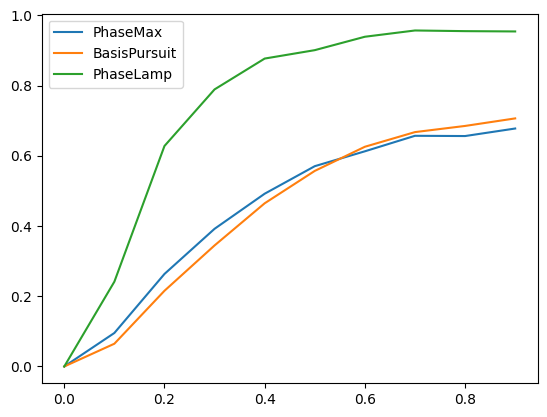

In [37]:
n = 100
ms = 500
sigma = np.arange(0.0,1,0.1)

errors = np.zeros(len(sigma))
success = np.zeros(len(sigma)) # less than 10^-5
success_7 = np.zeros(len(sigma)) # error bound in thm 7
p_7 = np.zeros(len(sigma)) # probability of success in thm 7

repeats = 10

def error_cal(xsol, x0):
    alpha = inp(x0,xsol)/(inp(xsol,xsol))
    sol = alpha * xsol
    error = la.norm(x0-sol)**2/la.norm(x0)**2
    return error

errors = {"PhaseMax": [], "PhaseLift": [], "BasisPursuit": [], "PhaseLamp": [], "PhaseCut":[]}

for i in range(len(sigma)):
    errorPM = 0
    errorPL = 0
    errorBP = 0
    errorPC = 0
    errorPLamp = 0
    for _ in range(repeats):
        noise = np.random.normal(0, sigma[i], ms)
        Data = GaussData(n,ms,True)
        #Data.b = Data.b + np.abs(noise) # if we only add positive noise
        Data.b = Data.b + noise
        negative_indices = np.where(Data.b <= 0)[0]
        
        #Remove corresponding columns from A
        Data.A = np.delete(Data.A, negative_indices, axis=0)
        Data.b = Data.b[Data.b > 0]
        
        m = len(Data.b)

        B = np.diag((Data.b))
       
        ### Theorem 7 in PM
        # s2 = np.min((bn**2)/(Data.b**2))
        # r = 1/np.sqrt(s2)*max(Data.b**2 -s2*Data.b + noise/Data.b)
        # epsilon = r/2 + 10e-5
        # phi = np.arccos(r/(2*epsilon))-25/180*np.pi 
        # suc = epsilon/(la.norm(Data.x0))+(1-np.sqrt(s2))
        # p = 1-np.power(np.exp(1)*m,2*n)*np.sqrt(2*n-1)/(np.power(4*n,2*n-1)) * np.exp(-np.power(np.sin(phi),(2*n))*(m-n)/(np.sqrt(16*n)))*np.cos(phi)-np.exp(-((m-4*n+1)**2)/(2*m-2))
        
        xhat = init_angle(Data.x0, 25/180*np.pi)

        ### PHASELAMP
        x_PLamp = PhaseLamp(Data.A,Data.b,xhat, k=10, epsilon = 10e-4,verbose=False, isComplex=True)
        errorPLamp += error_cal(x_PLamp, Data.x0)

        ### PHASEMAX
        x_PM = PhaseMax(Data.A, Data.b, xhat ,isComplex =True, verbose=False)
        errorPM += error_cal(x_PM, Data.x0)

        # ### PHASELIFT
        # x_PL = PhaseLift(Data.A, Data.b,verbose=False, isComplex=True)
        # errorPL += error_cal(x_PL)

        ### BASIS PURSUIT
        B1 = np.diag(1/(Data.b))
        D = np.conj((Data.A).T)@B1
        zsol = basis_pursuit(m,D,xhat,verbose=False, isComplex=True)
        zb = zsol/abs(zsol)
        xsol = la.lstsq(Data.A,B@zb,rcond=None)[0]
        alpha = inp(Data.x0,xsol)/(inp(xsol,xsol))
        sol = alpha * xsol
        error = la.norm(Data.x0-sol)**2/la.norm(Data.x0)**2
        errorBP += error

        ### PHASECUT
        x_PC= PhaseCut(Data.A, Data.b,verbose=False, isComplex=True)
        xsol = la.lstsq(Data.A,B@x_PC,rcond=None)[0]
        errorPC += error_cal(xsol)

    errors["PhaseMax"].append(errorPM/repeats)
    errors["PhaseLift"].append(errorPL/repeats)
    errors["BasisPursuit"].append(errorBP/repeats)
    errors["PhaseCut"].append(errorPC/repeats)
    errors["PhaseLamp"].append(errorPLamp/repeats)

    
plt.plot(sigma, errors["PhaseMax"], label="PhaseMax")
#plt.plot(sigma, errors["PhaseLift"], label="PhaseLift")
plt.plot(sigma, errors["BasisPursuit"], label="BasisPursuit")
#plt.plot(sigma, errors["PhaseCut"], label="PhaseCut")
plt.plot(sigma, errors["PhaseLamp"], label="PhaseLamp")
plt.legend()
plt.show()